In [9]:
import torch
import matplotlib.pyplot as plt

from data import get_dataset
from guided_diffusion.unet import create_model
from guided_diffusion.gaussian_diffusion import create_sampler
from util.img_utils import clear_color
from util.plot_utils import show_reconstruction
from tasks import create_operator
from gibbs_sampler import GibbsSampler


In [2]:
# Check device
device_str = "cuda:" if torch.cuda.is_available() else 'cpu'
device = torch.device(device_str)

In [3]:
# Here, we will focus on gaussian blur operator
operator_config = {
    "name": "gaussian_blur",
    "kernel_size": 61,
    "intensity": 3.0,
    "channels": 3,
    "img_dim": 256
}

# Create the linear operator
H_gaussian = create_operator(**operator_config, device=device)


In [4]:
# Get the test dataset
dataset_ffhq = get_dataset("ffhq", root="data/samples_ffhq")
dataset_celeba = get_dataset("celeba", root="data/samples_celeba")

sample_ffhq = dataset_ffhq[0]
sample_celeba = dataset_celeba[0]


In [5]:
sample_ffhq.shape

torch.Size([3, 256, 256])

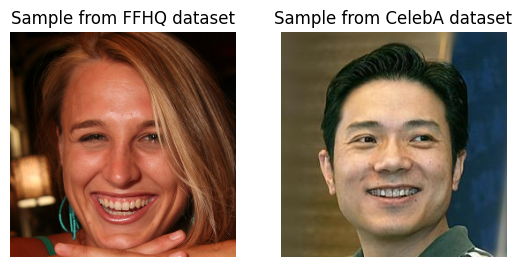

In [6]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(clear_color(sample_ffhq))
axes[0].set_title(f'Sample from FFHQ dataset')
axes[0].set_axis_off()

axes[1].imshow(clear_color(sample_celeba))
axes[1].set_title(f'Sample from CelebA dataset')
axes[1].set_axis_off()

plt.show()


## With DDMP model as a denoiser

In [ ]:
# Select configurations for the sampler in the case of diffusion
diffusion_config = {
    "sampler": "ddpm",
    "steps": 1000,
    "noise_schedule": "linear",
    "model_mean_type": "epsilon",
    "model_var_type": "learned_range",
    "dynamic_threshold": False,
    "clip_denoised": True,
    "rescale_timesteps": False,
    "timestep_respacing": 1000
}

# Create sampler to be used in the case of diffusion
diffusion_sampler = create_sampler(**diffusion_config)

In [ ]:
# Now, get the pre-trained diffusion model
possible_diffusion_models = {'ffhq_10m':'models/ffhq_10m.pt', 'imagenet':'models/imagenet256.pt', 'random': ''}

# Base configurations

model_config_base = {
    "image_size": 256,
    "num_channels": 128,
    "num_res_blocks": 1,
    "channel_mult": "",
    "learn_sigma": True,
    "class_cond": False,
    "use_checkpoint": False,
    "attention_resolutions": 16,
    "num_heads": 4,
    "num_head_channels": 64,
    "num_heads_upsample": -1,
    "use_scale_shift_norm": True,
    "dropout": 0.0,
    "resblock_updown": True,
    "use_fp16": False,
    "use_new_attention_order": False,
}

# With ffhq_10m
model_config = model_config_base.copy()
model_config["model_path"] = possible_diffusion_models['ffhq_10m']

# Random initialization
model_config_random = model_config_base.copy()
model_config_random["model_path"] = possible_diffusion_models['random']

# Init and load pretrained model, and put in inference mode
model_type = 'DDMP'
model_DDMP = create_model(**model_config)
model_DDMP.to(device)
model_DDMP.eval()

model_DDMP_random = create_model(**model_config_random)
model_DDMP_random.to(device)
model_DDMP_random.eval()

## Sample

In here, we use the fact that we divide our problem in (1) sampling x such that x is close to z and (2) sampling z as a denoised image

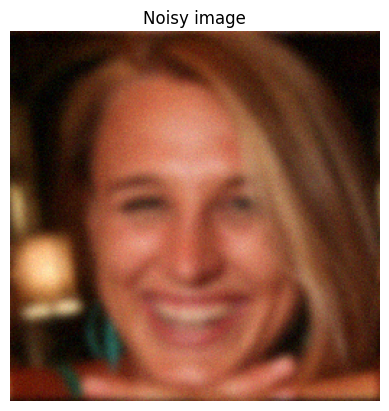

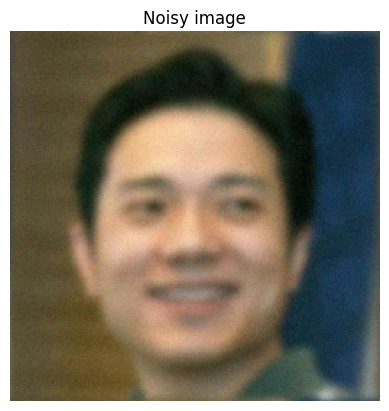

In [8]:
# Lets see with just one test sample
X = {'ffhq': sample_ffhq, 'celeba': sample_celeba}
Y = {}
for name in X.keys():
    x = X[name]
    y = H_gaussian.forward(x)
    sigma = torch.tensor(0.05).to(device)
    # Creating the noisy image Y = HX + n
    y = y + sigma*torch.randn(x.shape).to(device)
    Y[name] = y
    # Plot noisy image
    fig, ax = plt.subplots()
    ax.imshow(clear_color(y))
    ax.set_title('Noisy image')
    ax.axis('off')
    plt.savefig(f"results/image_{name}_noisy.png", dpi=200, bbox_inches='tight')

    plt.show()


In [ ]:

# Execute sampling

def execute_sampling(noisy_img, name, model, model_type, N_bi = 20, N_MC = 23):

    gibbs = GibbsSampler(
                         Y=noisy_img,
                         sigma=sigma,
                         operator=H_gaussian,
                         sampler=diffusion_sampler,
                         model=model,
                         model_type=model_type,
                         device=device,
                         N_MC=23,
                         N_bi=20,
                         rho=0.1,
                         rho_decay_rate=0.8,
                         plot_process = 5)

    X_MC, Z_MC = gibbs.run()

    show_reconstruction(torch.mean(Z_MC[:,:,:,N_bi:N_MC], axis=-1), torch.mean(X_MC[:,:,:,N_bi:N_MC], axis=-1), 'final')

    fig, axes = plt.subplots(2, 3, figsize=(20, 20))

    for i in range(N_MC-N_bi):
        axes[0,i].imshow(clear_color(torch.mean(Z_MC[:,:,:,N_bi:N_MC], axis=-1)))
        axes[0,i].set_title(f'Sample {i}')
        axes[0,i].axis('off')

        axes[1,i].imshow(clear_color(torch.mean(X_MC[:,:,:,N_bi:N_MC], axis=-1)))
        axes[1,i].axis('off')

    plt.savefig(f"results/example_{name}_test.png", dpi=200, bbox_inches='tight')

## Comparing with the output after one diffusion step back

Here, we are estimating the noise level of the original image Y, and then passing it to backward diffusion to recover an estimative of X